# Univariate with exogenous variables


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.dates as mdates
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sktime.forecasting.var import VAR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.model_selection import temporal_train_test_split

warnings.filterwarnings("ignore")

In [2]:
data_case = pd.read_csv("../data/data_2023-Nov-16.csv")
data_case.head()

,areaType,areaName,areaCode,date,newCasesBySpecimenDate,cumCasesBySpecimenDate,newFirstEpisodesBySpecimenDate,cumFirstEpisodesBySpecimenDate,newReinfectionsBySpecimenDate,cumReinfectionsBySpecimenDate
0,nation,England,E92000001,2023-11-14,355,21003340,NaN,19370997,NaN,1631595.0
1,nation,England,E92000001,2023-11-13,606,21002985,198.0,19370997,177.0,1631595.0
2,nation,England,E92000001,2023-11-12,531,21002379,276.0,19370799,210.0,1631418.0
3,nation,England,E92000001,2023-11-11,210,21001848,132.0,19370523,57.0,1631208.0
4,nation,England,E92000001,2023-11-10,150,21001638,80.0,19370391,32.0,1631151.0


In [3]:
data_case = data_case[["date", "newCasesBySpecimenDate"]]
data_case = data_case.rename(columns={"newCasesBySpecimenDate": "new_cases"})
data_case["date"] = pd.to_datetime(data_case["date"])
data_case = data_case.set_index("date")
data_case.head()

,new_cases
date,
2023-11-14,355
2023-11-13,606
2023-11-12,531
2023-11-11,210
2023-11-10,150


In [4]:
data_death = pd.read_csv("../data/data_2023-Nov-16 (2).csv")
data_death.head()

,areaType,areaName,areaCode,date,newDailyNsoDeathsByDeathDate,cumDailyNsoDeathsByDeathDate
0,nation,England,E92000001,2023-10-20,45,196386
1,nation,England,E92000001,2023-10-19,48,196341
2,nation,England,E92000001,2023-10-18,45,196293
3,nation,England,E92000001,2023-10-17,50,196248
4,nation,England,E92000001,2023-10-16,39,196198


In [5]:
data_mv = pd.read_csv("../data/data_2023-Nov-16 (4).csv")
data_mv.head()

,areaType,areaName,areaCode,date,covidOccupiedMVBedsWeekly
0,nation,England,E92000001,2023-05-26,79
1,nation,England,E92000001,2023-05-19,92
2,nation,England,E92000001,2023-05-12,102
3,nation,England,E92000001,2023-05-05,100
4,nation,England,E92000001,2023-04-28,94


In [6]:
data_vacc = pd.read_csv("../data/data_2023-Nov-16 (5).csv")
data_vacc.head()

,areaType,areaName,areaCode,date,newVaccinesGivenByPublishDate,cumVaccinesGivenByPublishDate,newPeopleVaccinatedFirstDoseByPublishDate,cumPeopleVaccinatedFirstDoseByPublishDate,newPeopleVaccinatedSecondDoseByPublishDate,cumPeopleVaccinatedSecondDoseByPublishDate,newPeopleVaccinatedThirdInjectionByPublishDate,cumPeopleVaccinatedThirdInjectionByPublishDate
0,nation,England,E92000001,2023-11-15,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
1,nation,England,E92000001,2023-11-14,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
2,nation,England,E92000001,2023-11-13,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
3,nation,England,E92000001,2023-11-12,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
4,nation,England,E92000001,2023-11-11,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0


In [7]:
# Creating the dataframe from the provided data
admission_data = pd.DataFrame(
    {
        "AgeGroup": ["85+", "65 - 84", "6 - 17", "18 - 64", "0 - 5"],
        "AdmissionsUnsorted": [238128, 443513, 15230, 366215, 24881],
        "AdmissionRateUnsorted": [16931.6, 4896.6, 186.5, 1077.3, 633.3],
    }
)

# Sorting the data as requested
admission_data_sorted = admission_data.sort_values(by=["AgeGroup"], ascending=True)
# Save the sorted DataFrame to a CSV file
admission_data_sorted.to_csv("../data/sorted_admissions_data.csv", index=False)

In [8]:
admission_data_sorted

,AgeGroup,AdmissionsUnsorted,AdmissionRateUnsorted
4,0 - 5,24881,633.3
3,18 - 64,366215,1077.3
2,6 - 17,15230,186.5
1,65 - 84,443513,4896.6
0,85+,238128,16931.6


In [9]:
fil_dt = pd.read_csv("../data/filtered_data.csv")
fil_dt.head()

,areaCode,areaName,areaType,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions
0,E40000007,East of England,nhsRegion,2023-05-31,5.0,105345,262.0,40
1,E40000007,East of England,nhsRegion,2023-05-30,3.0,105305,252.0,40
2,E40000007,East of England,nhsRegion,2023-05-29,4.0,105265,258.0,51
3,E40000007,East of England,nhsRegion,2023-05-28,6.0,105214,261.0,32
4,E40000007,East of England,nhsRegion,2023-05-27,8.0,105182,263.0,27


In [10]:
fil_dt["date"] = pd.to_datetime(fil_dt["date"])
# Select only relevant columns for aggregation
agg_columns = ["covidOccupiedMVBeds", "cumAdmissions", "hospitalCases", "newAdmissions"]
agg_fil_dt = fil_dt.groupby(["date"])[agg_columns].sum()

# Display the aggregated data
agg_fil_dt.head()

,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions
date,,,,
2020-04-02,1494.0,26264,12135.0,2932
2020-04-03,1788.0,28828,13635.0,2564
2020-04-04,1950.0,31421,15469.0,2593
2020-04-05,2097.0,34013,16657.0,2592
2020-04-06,2264.0,36692,17154.0,2679


In [11]:
agg_fil_dt.to_csv("../data/agg_filtered_data.csv")

In [12]:
# gb_data = pd.read_csv("../data/2022_GB_Region_Mobility_Report.csv")
# gb_data.head(10)

In [13]:
# File paths for the CSV files
file_paths = [
    "../data/data_2023-Nov-16.csv",
    "../data/data_2023-Nov-16 (1).csv",
    "../data/data_2023-Nov-16 (2).csv",
    "../data/data_2023-Nov-16 (3).csv",
    "../data/data_2023-Nov-16 (4).csv",
    "../data/data_2023-Nov-16 (5).csv",
    "../data/agg_filtered_data.csv",
    # "../data/2022_GB_Region_Mobility_Report.csv"
]

# Loading the datasets
datasets = [pd.read_csv(file) for file in file_paths]

# Check column names in each dataset
for i, dataset in enumerate(datasets):
    print(f"Dataset {i} columns: {dataset.columns.tolist()}")

# Selecting relevant columns from each dataset
# gb_data = datasets[7][["date", "transit_stations_percent_change_from_baseline"]]
mv_beds_occupied = datasets[6][["date", "covidOccupiedMVBeds"]]
hospital_cases = datasets[6][["date", "hospitalCases"]]
new_admissions = datasets[6][["date", "newAdmissions"]]

# Dataset 0 - New COVID-19 Cases
new_cases = datasets[0][["date", "newCasesBySpecimenDate"]]

# Dataset 2 - New COVID-19 Deaths
# new_deaths = datasets[2][["date", "newDailyNsoDeathsByDeathDate"]]

# Dataset 5 - New Vaccinations
# new_vaccinations = datasets[5][["date", "newVaccinesGivenByPublishDate"]]


# Merging all datasets on the 'date' column
combined_data = pd.merge(mv_beds_occupied, hospital_cases, on="date", how="outer")
combined_data = pd.merge(combined_data, new_admissions, on="date", how="outer")
combined_data = pd.merge(combined_data, new_cases, on="date", how="outer")
# combined_data = pd.merge(combined_data, new_deaths, on="date", how="outer")
# combined_data = pd.merge(combined_data, new_vaccinations, on="date", how="outer")
# combined_data = pd.merge(combined_data, gb_data, on="date", how="outer")

# Ensuring 'date' column is in datetime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Renaming columns for clarity
combined_data.columns = [
    "date",
    "MV Beds Occupied",
    "Hospital Cases",
    "New Admissions",
    "New COVID-19 Cases",
    # "New COVID-19 Deaths",
    # "New Vaccinations",
    # "transit stations%_change"
]

# Displaying the combined dataframe
combined_data.head()

Dataset 0 columns: ['areaType', 'areaName', 'areaCode', 'date', 'newCasesBySpecimenDate', 'cumCasesBySpecimenDate', 'newFirstEpisodesBySpecimenDate', 'cumFirstEpisodesBySpecimenDate', 'newReinfectionsBySpecimenDate', 'cumReinfectionsBySpecimenDate']
Dataset 1 columns: ['areaType', 'areaName', 'areaCode', 'date', 'newCasesBySpecimenDateAgeDemographics']
Dataset 2 columns: ['areaType', 'areaName', 'areaCode', 'date', 'newDailyNsoDeathsByDeathDate', 'cumDailyNsoDeathsByDeathDate']
Dataset 3 columns: ['areaType', 'areaName', 'areaCode', 'date', 'newAdmissionsWeekly', 'cumAdmissions']
Dataset 4 columns: ['areaType', 'areaName', 'areaCode', 'date', 'covidOccupiedMVBedsWeekly']
Dataset 5 columns: ['areaType', 'areaName', 'areaCode', 'date', 'newVaccinesGivenByPublishDate', 'cumVaccinesGivenByPublishDate', 'newPeopleVaccinatedFirstDoseByPublishDate', 'cumPeopleVaccinatedFirstDoseByPublishDate', 'newPeopleVaccinatedSecondDoseByPublishDate', 'cumPeopleVaccinatedSecondDoseByPublishDate', 'newPeop

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases
0,2020-04-02,1494.0,12135.0,2932.0,4097
1,2020-04-03,1788.0,13635.0,2564.0,4102
2,2020-04-04,1950.0,15469.0,2593.0,3405
3,2020-04-05,2097.0,16657.0,2592.0,3094
4,2020-04-06,2264.0,17154.0,2679.0,4407


In [14]:
# combined_data["New Vaccinations"] = combined_data["New Vaccinations"].fillna(0)
# combined_data.head()

In [15]:
# Function to calculate the Vax index based on the given description and assumptions
def calculate_vax_index(df):
    # Constants for population and vaccination
    total_population = 60_000_000
    number_of_age_groups = 5
    vaccine_efficacy_first_dose = [0.89, 0.427, 0.76, 0.854]
    vaccine_efficacy_second_dose = [0.92, 0.86, 0.81, None]
    age_group_probabilities_icu = [
        0.01,
        0.02,
        0.05,
        0.1,
        0.15,
    ]  # Hypothetical ICU need probabilities for different age groups
    monthly_vaccination_rate_increase = 0.05
    # Constants for Vaccination start date
    vaccination_start_date = pd.Timestamp("2021-01-18")

    # Divide population into age groups
    population_per_age_group = total_population / number_of_age_groups

    # Initialize Vax index list
    vax_index_list = []

    # Monthly vaccination rate (starting from 0)
    monthly_vaccination_rate = 0

    # Calculate Vax index for each day
    for index, row in df.iterrows():
        # Initialize Si sum for all age groups
        Si_sum = 0

        # If after vaccination start date, increase monthly vaccination rate
        if row["date"].day == 1 and row["date"] > vaccination_start_date:
            monthly_vaccination_rate += monthly_vaccination_rate_increase

        # Calculate Si and Vax index for each age group
        for i in range(number_of_age_groups):
            # Assume vaccination distribution across age groups (aij: two doses, bij: one dose, cij: no doses)
            vaccinated_population = monthly_vaccination_rate * population_per_age_group
            aij = vaccinated_population / 2
            bij = vaccinated_population / 2
            cij = population_per_age_group - aij - bij

            # Calculate S''i based on vaccine efficacy and distribution
            S_double_prime_i = sum(
                wj * aij + vj * (bij - aij)
                for wj, vj in zip(
                    vaccine_efficacy_second_dose, vaccine_efficacy_first_dose
                )
                if wj is not None
            )

            # Calculate Si
            Si = aij + bij + cij - S_double_prime_i

            # Age-specific probability (pi)
            pi = age_group_probabilities_icu[i]

            # Sum Si for all age groups
            Si_sum += pi * (aij + bij + cij - S_double_prime_i) / (aij + bij + cij)

        # Calculate Vax index for the day
        vax_index = Si_sum
        vax_index_list.append(vax_index)

    # Add Vax index to the dataframe
    df["Vax_index"] = vax_index_list
    return df


# Calculating Vax index for the data
combined_data = calculate_vax_index(combined_data.copy())

In [16]:
combined_data.head()

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index
0,2020-04-02,1494.0,12135.0,2932.0,4097,0.33
1,2020-04-03,1788.0,13635.0,2564.0,4102,0.33
2,2020-04-04,1950.0,15469.0,2593.0,3405,0.33
3,2020-04-05,2097.0,16657.0,2592.0,3094,0.33
4,2020-04-06,2264.0,17154.0,2679.0,4407,0.33


In [17]:
combined_data.to_csv("../data/england_data.csv", index=True)

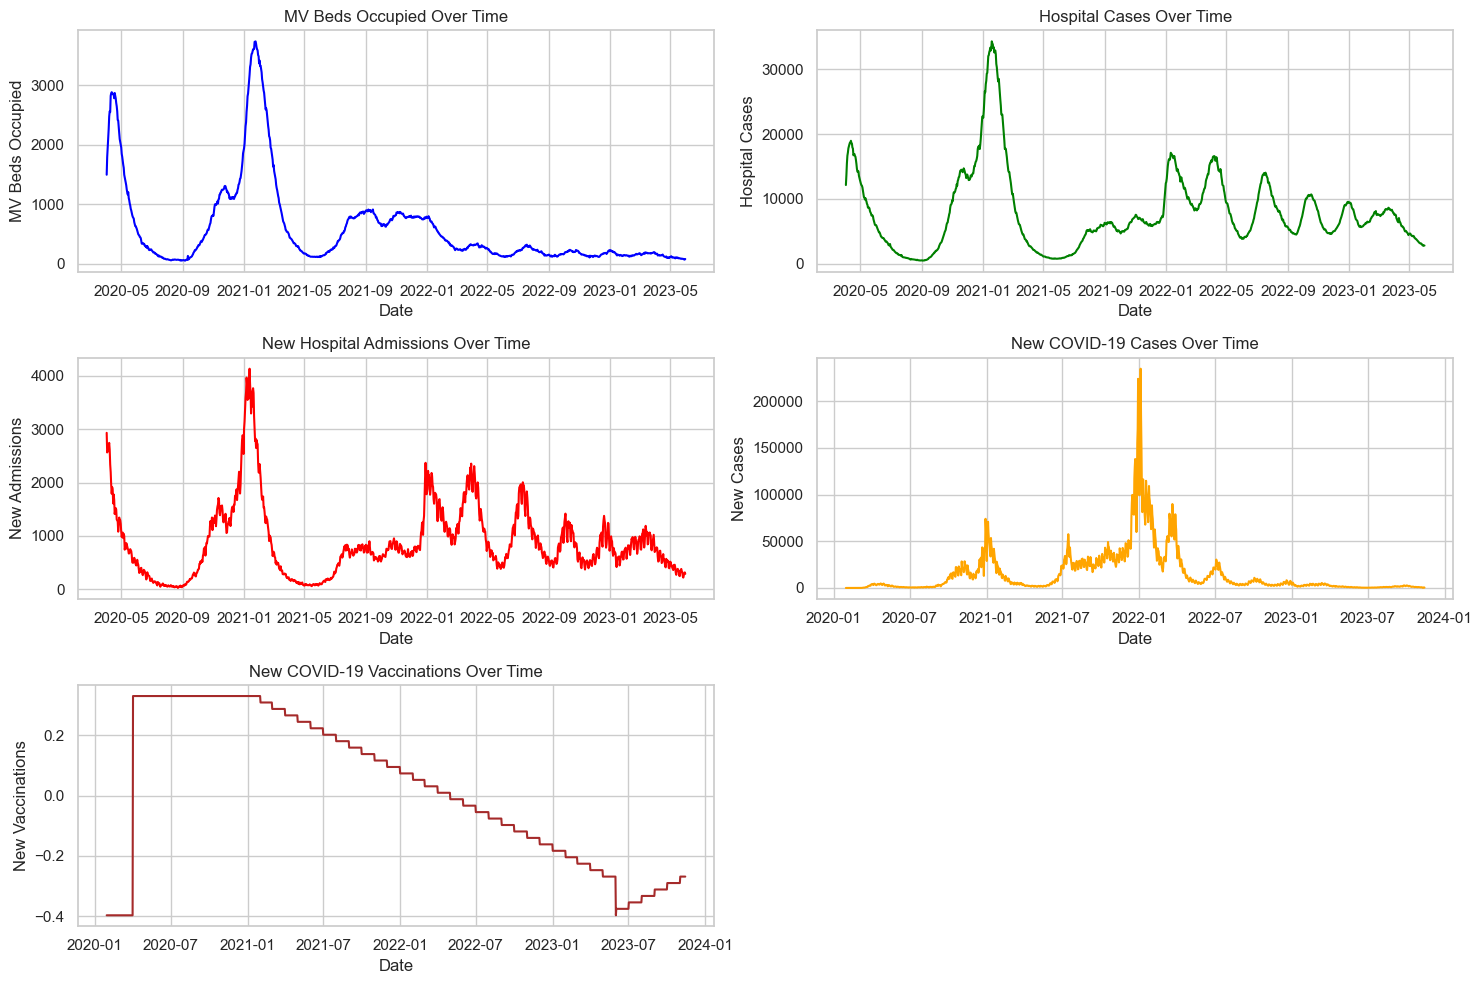

In [18]:
# Setting the visualization style
sns.set(style="whitegrid")

# Visualizing all the data
plt.figure(figsize=(15, 10))

# MV Beds Occupied
plt.subplot(3, 2, 1)
sns.lineplot(data=combined_data, x="date", y="MV Beds Occupied", color="blue")
plt.title("MV Beds Occupied Over Time")
plt.xlabel("Date")
plt.ylabel("MV Beds Occupied")

# Hospital Cases
plt.subplot(3, 2, 2)
sns.lineplot(data=combined_data, x="date", y="Hospital Cases", color="green")
plt.title("Hospital Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Hospital Cases")

# New Admissions
plt.subplot(3, 2, 3)
sns.lineplot(data=combined_data, x="date", y="New Admissions", color="red")
plt.title("New Hospital Admissions Over Time")
plt.xlabel("Date")
plt.ylabel("New Admissions")

# New COVID-19 Cases
plt.subplot(3, 2, 4)
sns.lineplot(data=combined_data, x="date", y="New COVID-19 Cases", color="orange")
plt.title("New COVID-19 Cases Over Time")
plt.xlabel("Date")
plt.ylabel("New Cases")

# # New COVID-19 Deaths
# plt.subplot(3, 2, 5)
# sns.lineplot(data=combined_data, x="date", y="New COVID-19 Deaths", color="purple")
# plt.title("New COVID-19 Deaths Over Time")
# plt.xlabel("Date")
# plt.ylabel("New Deaths")

# # New Vaccinations
# plt.subplot(3, 2, 6)
# sns.lineplot(data=combined_data, x="date", y="New Vaccinations", color="brown")
# plt.title("New COVID-19 Vaccinations Over Time")
# plt.xlabel("Date")
# plt.ylabel("New Vaccinations")

plt.subplot(3, 2, 5)
sns.lineplot(data=combined_data, x="date", y="Vax_index", color="brown")
plt.title("New COVID-19 Vaccinations Over Time")
plt.xlabel("Date")
plt.ylabel("New Vaccinations")

plt.tight_layout()
plt.show()

In [19]:
# Define start and end date for the Alpha variant period
start_alpha = "2020-04-02"
end_alpha = "2021-12-31"

model_data = combined_data.loc[
    (combined_data["date"] >= start_alpha) & (combined_data["date"] <= end_alpha)
]
model_data.head()

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index
0,2020-04-02,1494.0,12135.0,2932.0,4097,0.33
1,2020-04-03,1788.0,13635.0,2564.0,4102,0.33
2,2020-04-04,1950.0,15469.0,2593.0,3405,0.33
3,2020-04-05,2097.0,16657.0,2592.0,3094,0.33
4,2020-04-06,2264.0,17154.0,2679.0,4407,0.33


In [20]:
model_data.to_csv("../data/model_data.csv")

In [21]:
# Example for the High Infection Scenario
model_data["Year"] = model_data["date"].dt.year
model_data["Month"] = model_data["date"].dt.month
model_data["Day"] = model_data["date"].dt.day

# Drop the original 'Date' column
model_data.drop("date", axis=1, inplace=True)

In [22]:
X = model_data.drop(
    ["MV Beds Occupied", "Vax_index"], axis=1
)
y = model_data["MV Beds Occupied"]

y.head()

0    1494.0
1    1788.0
2    1950.0
3    2097.0
4    2264.0
Name: MV Beds Occupied, dtype: float64

In [23]:
X.head()

,Hospital Cases,New Admissions,New COVID-19 Cases,Year,Month,Day
0,12135.0,2932.0,4097,2020,4,2
1,13635.0,2564.0,4102,2020,4,3
2,15469.0,2593.0,3405,2020,4,4
3,16657.0,2592.0,3094,2020,4,5
4,17154.0,2679.0,4407,2020,4,6


In [24]:
fh = np.arange(1, 90)
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=fh)
# fh = ForecastingHorizon(y_test.index, is_relative=False)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def calculate_metrics(y_test, y_pred, model_name="Model"):
    """
    Calculate performance metrics for a given model and return them in a DataFrame.

    :param y_test: Array-like, true target values.
    :param y_pred: Array-like, predicted target values.
    :param model_name: String, name of the model.

    :return: DataFrame with metrics.
    """
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred),
    }

    return pd.DataFrame(metrics, index=[model_name])

In [26]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster

# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train, X=X_train)

NaiveForecaster(sp=12)

In [27]:
y_pred = forecaster.predict(fh=fh, X=X_pred)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='MV Beds Occupied'>)

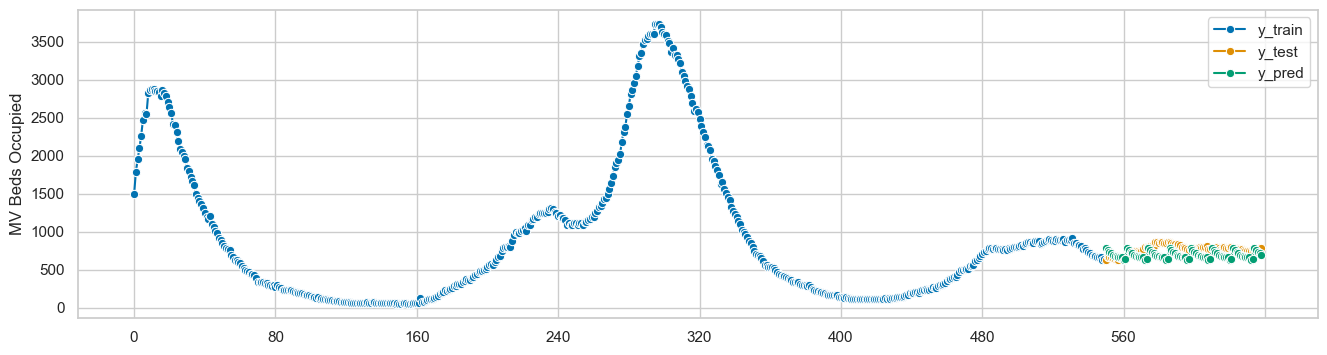

In [28]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [29]:
model_metrics_df = calculate_metrics(y_test, y_pred, "NaiveForecaster")

In [30]:
print(model_metrics_df)

                       MAE          MSE        RMSE       R2
NaiveForecaster  90.775281  11110.88764  105.408195 -2.07142


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\pyt_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\olarinoyem\AppData\Local\miniconda3\envs\pyt_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\olarinoyem\AppData\Local\miniconda3\envs\pyt_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\olarinoyem\AppData\Local\miniconda3\envs\pyt_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Like

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='MV Beds Occupied'>)

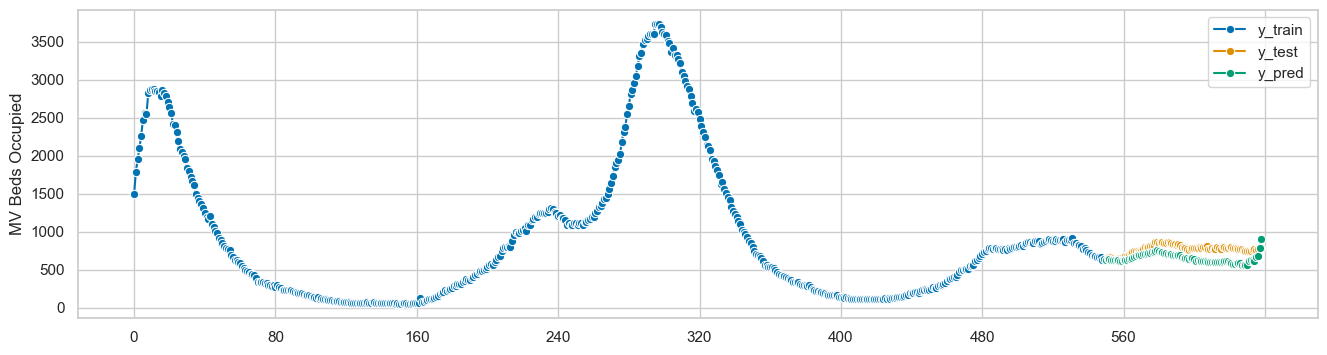

In [31]:
forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh=fh, X=X_pred)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [32]:
results_df = calculate_metrics(y_test, y_pred, "AutoARIMA")

In [33]:
print(results_df)

                  MAE           MSE        RMSE        R2
AutoARIMA  122.650121  18539.988118  136.161625 -4.125072


In [34]:
# Combine the metrics DataFrames
combined_metrics_df = pd.concat([model_metrics_df, results_df])

# Display the combined metrics
combined_metrics_df

,MAE,MSE,RMSE,R2
NaiveForecaster,90.775281,11110.887640,105.408195,-2.071420
AutoARIMA,122.650121,18539.988118,136.161625,-4.125072


## Scenario Analysis in Forecasting Demand for Mechanical Ventilators

- **Scenerio A (high infection rate)**
- **Scenerio B (Increased Hospitalisation rate)**
- **Scenerio C (Efectiuve Vaccination Campaign)**
- **Scenerio D (Resource Strain)**


In [35]:
# Filter data for 2020 and early 2021
combined_data["date"] = pd.to_datetime(combined_data["date"])
data_2020_early_2021 = combined_data[
    (combined_data["date"].dt.year == 2020)
    | ((combined_data["date"].dt.year == 2021) & (combined_data["date"].dt.month <= 4))
]

# High Infection and Hospitalization Scenario
data_high_infection = data_2020_early_2021.copy()
data_high_infection["New COVID-19 Cases"] *= 1.5
data_high_infection["New Admissions"] *= 1.5

# Effective Vaccination Scenario
data_effective_vaccination = data_2020_early_2021.copy()
data_effective_vaccination["New Admissions"] *= 0.7
data_effective_vaccination["MV Beds Occupied"] *= 0.7

# Resource Strain Scenario
data_resource_strain = data_2020_early_2021.copy()
data_resource_strain["Hospital Cases"] *= 1.25
data_resource_strain["MV Beds Occupied"] *= 1.25

In [36]:
data_high_infection.head()

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index
0,2020-04-02,1494.0,12135.0,4398.0,6145.5,0.33
1,2020-04-03,1788.0,13635.0,3846.0,6153.0,0.33
2,2020-04-04,1950.0,15469.0,3889.5,5107.5,0.33
3,2020-04-05,2097.0,16657.0,3888.0,4641.0,0.33
4,2020-04-06,2264.0,17154.0,4018.5,6610.5,0.33


In [37]:
# Example for the High Infection Scenario
data_high_infection["Year"] = data_high_infection["date"].dt.year
data_high_infection["Month"] = data_high_infection["date"].dt.month
data_high_infection["Day"] = data_high_infection["date"].dt.day

# Drop the original 'Date' column
data_high_infection.drop("date", axis=1, inplace=True)

In [38]:
# Creating an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy="mean")

In [39]:
X = data_high_infection.drop("MV Beds Occupied", axis=1)
y = data_high_infection["MV Beds Occupied"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [40]:
X_train

,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index,Year,Month,Day
17,16928.0,2212.5,5241.0,0.330000,2020,4,19
66,4820.0,484.5,1002.0,0.330000,2020,6,7
1338,NaN,NaN,828.0,-0.396495,2020,3,16
320,17093.0,1966.5,16902.0,0.308632,2021,2,16
31,12119.0,1566.0,3972.0,0.330000,2020,5,3
...,...,...,...,...,...,...,...
106,1346.0,124.5,822.0,0.330000,2020,7,17
270,20426.0,4192.5,61267.5,0.330000,2020,12,28
348,5664.0,546.0,7399.5,0.287265,2021,3,16
1363,NaN,NaN,0.0,-0.396495,2020,2,20


In [41]:
import pandas as pd

data = pd.read_csv(
    "https://storage.googleapis.com/covid19-open-data/v3/location/GB_ENG.csv"
)

data.head(10)

,location_key,date,place_id,wikidata_id,country_code,country_name,subregion1_code,subregion1_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,...,facial_coverings,vaccination_policy,stringency_index,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
0,GB_ENG,2020-01-01,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,4.916667,1.847222,6.138889,0.108857,NaN,3.840278,92.753315
1,GB_ENG,2020-01-02,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,8.250000,5.673611,10.000000,0.000000,NaN,6.131944,86.523195
2,GB_ENG,2020-01-03,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.229167,4.381944,10.111111,0.465667,NaN,4.506944,82.876060
3,GB_ENG,2020-01-04,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,6.861111,4.187500,8.569444,0.217714,NaN,4.034722,82.214306
4,GB_ENG,2020-01-05,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.291667,4.625000,9.118056,0.000000,NaN,5.305556,87.216596
5,GB_ENG,2020-01-06,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.145833,4.805556,8.458333,0.000000,NaN,4.409722,82.768935
6,GB_ENG,2020-01-07,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,8.673611,3.444444,13.229167,0.423333,NaN,6.993056,89.209165
7,GB_ENG,2020-01-08,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,9.208333,5.743056,12.840278,0.203200,NaN,5.666667,78.549211
8,GB_ENG,2020-01-09,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,7.652778,4.750000,11.673611,12.107333,10.16,5.645833,87.136459
9,GB_ENG,2020-01-10,ChIJ39UebIqp0EcRqI4tMyWV4fQ,Q21,GB,United Kingdom,ENG,England,GB,GBR,...,0.0,0.0,0.0,4.708333,2.500000,7.118056,0.666750,NaN,2.250000,84.126813


In [42]:
print(data.columns)

Index(['location_key', 'date', 'place_id', 'wikidata_id', 'country_code',
       'country_name', 'subregion1_code', 'subregion1_name',
       'iso_3166_1_alpha_2', 'iso_3166_1_alpha_3', 'aggregation_level',
       'new_confirmed', 'new_deceased', 'new_tested', 'cumulative_confirmed',
       'cumulative_deceased', 'cumulative_tested', 'new_hospitalized_patients',
       'cumulative_hospitalized_patients', 'current_hospitalized_patients',
       'current_ventilator_patients', 'new_persons_vaccinated',
       'cumulative_persons_vaccinated', 'new_persons_fully_vaccinated',
       'cumulative_persons_fully_vaccinated', 'new_vaccine_doses_administered',
       'cumulative_vaccine_doses_administered', 'population',
       'population_male', 'population_female', 'population_age_00_09',
       'population_age_10_19', 'population_age_20_29', 'population_age_30_39',
       'population_age_40_49', 'population_age_50_59', 'population_age_60_69',
       'population_age_70_79', 'population_age_80_an

In [43]:
data.to_csv("../data/google_data.csv", index=False)

In [44]:
model_data = pd.read_csv("../data/model_data.csv")

In [45]:
additional_columns = [
    "date",
    "stringency_index",
    "average_temperature_celsius",
    "relative_humidity",
    "vaccination_policy",
    "emergency_investment_in_healthcare"
]

additional_features = data[additional_columns]

# Converting 'date' columns in both datasets to datetime for merging
additional_features["date"] = pd.to_datetime(additional_features["date"])
model_data["date"] = pd.to_datetime(model_data["date"])

# Merging the datasets on the date column
enriched_data = pd.merge(
    model_data, additional_features, left_on="date", right_on="date", how="left"
)

# Dropping redundant date column
enriched_data.drop(columns=["Unnamed: 0"], inplace=True)

# Display the first few rows of the enriched dataset
enriched_data.head()

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index,stringency_index,average_temperature_celsius,relative_humidity,vaccination_policy,emergency_investment_in_healthcare
0,2020-04-02,1494.0,12135.0,2932.0,4097,0.33,79.63,8.131944,71.895232,0.0,0.0
1,2020-04-03,1788.0,13635.0,2564.0,4102,0.33,79.63,7.250000,66.980840,0.0,0.0
2,2020-04-04,1950.0,15469.0,2593.0,3405,0.33,79.63,9.319444,66.459780,0.0,0.0
3,2020-04-05,2097.0,16657.0,2592.0,3094,0.33,79.63,12.291667,53.621480,0.0,0.0
4,2020-04-06,2264.0,17154.0,2679.0,4407,0.33,79.63,12.395833,59.204766,0.0,0.0


In [46]:
enriched_data.to_csv("../data/full_data.csv", index=False)

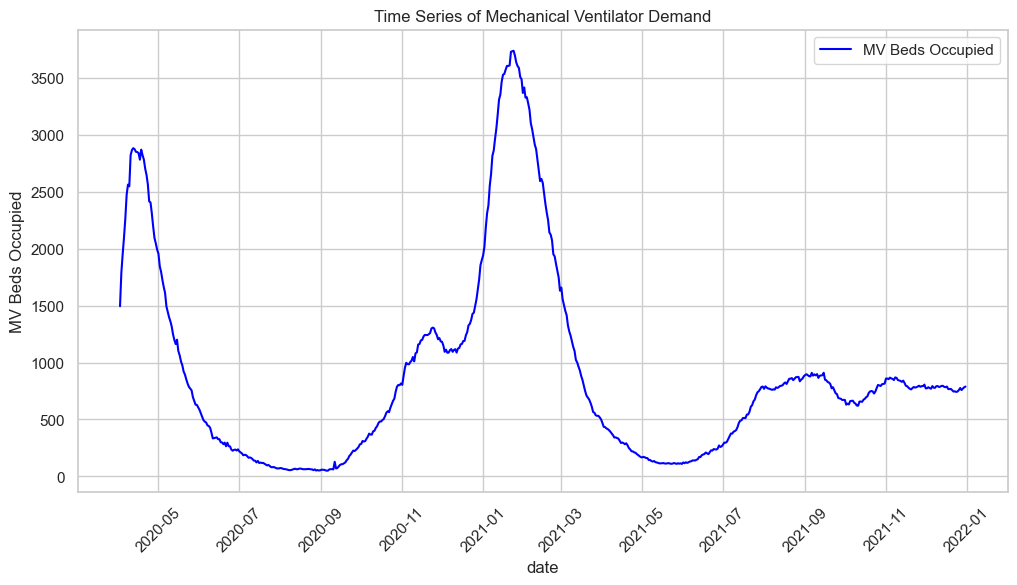

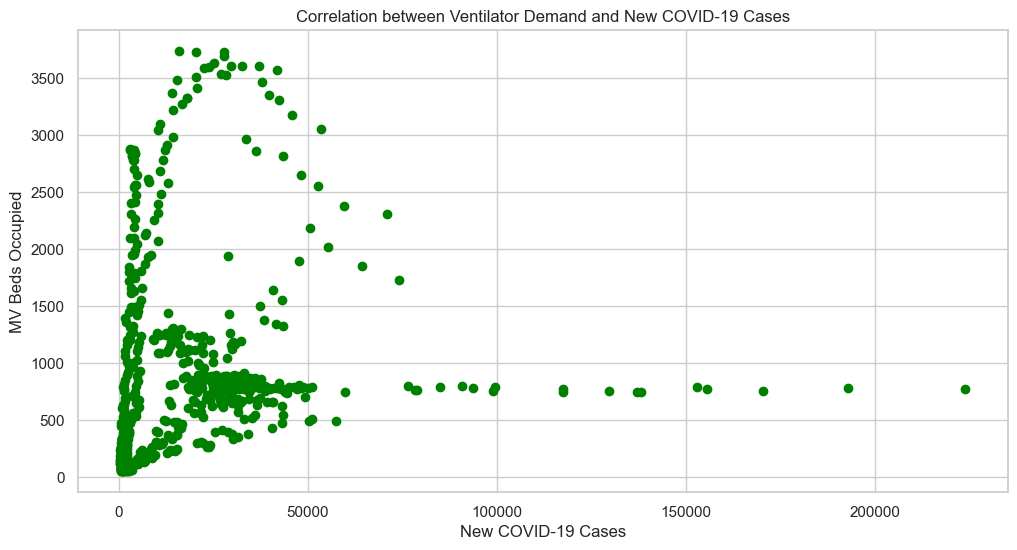

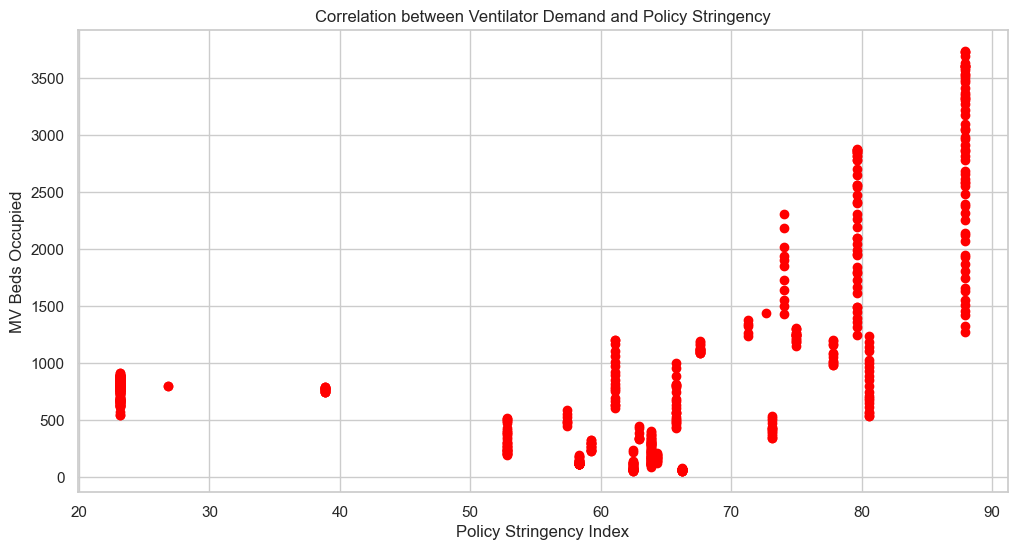

In [47]:
# Exploratory Data Analysis and Visualization

# Plotting time series of mechanical ventilator demand
plt.figure(figsize=(12, 6))
plt.plot(
    enriched_data["date"],
    enriched_data["MV Beds Occupied"],
    label="MV Beds Occupied",
    color="blue",
)
plt.title("Time Series of Mechanical Ventilator Demand")
plt.xlabel("date")
plt.ylabel("MV Beds Occupied")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plotting correlation between ventilator demand and new COVID-19 cases
plt.figure(figsize=(12, 6))
plt.scatter(
    enriched_data["New COVID-19 Cases"],
    enriched_data["MV Beds Occupied"],
    color="green",
)
plt.title("Correlation between Ventilator Demand and New COVID-19 Cases")
plt.xlabel("New COVID-19 Cases")
plt.ylabel("MV Beds Occupied")
plt.show()

# Plotting correlation between ventilator demand and policy stringency
plt.figure(figsize=(12, 6))
plt.scatter(
    enriched_data["stringency_index"], enriched_data["MV Beds Occupied"], color="red"
)
plt.title("Correlation between Ventilator Demand and Policy Stringency")
plt.xlabel("Policy Stringency Index")
plt.ylabel("MV Beds Occupied")
plt.show()

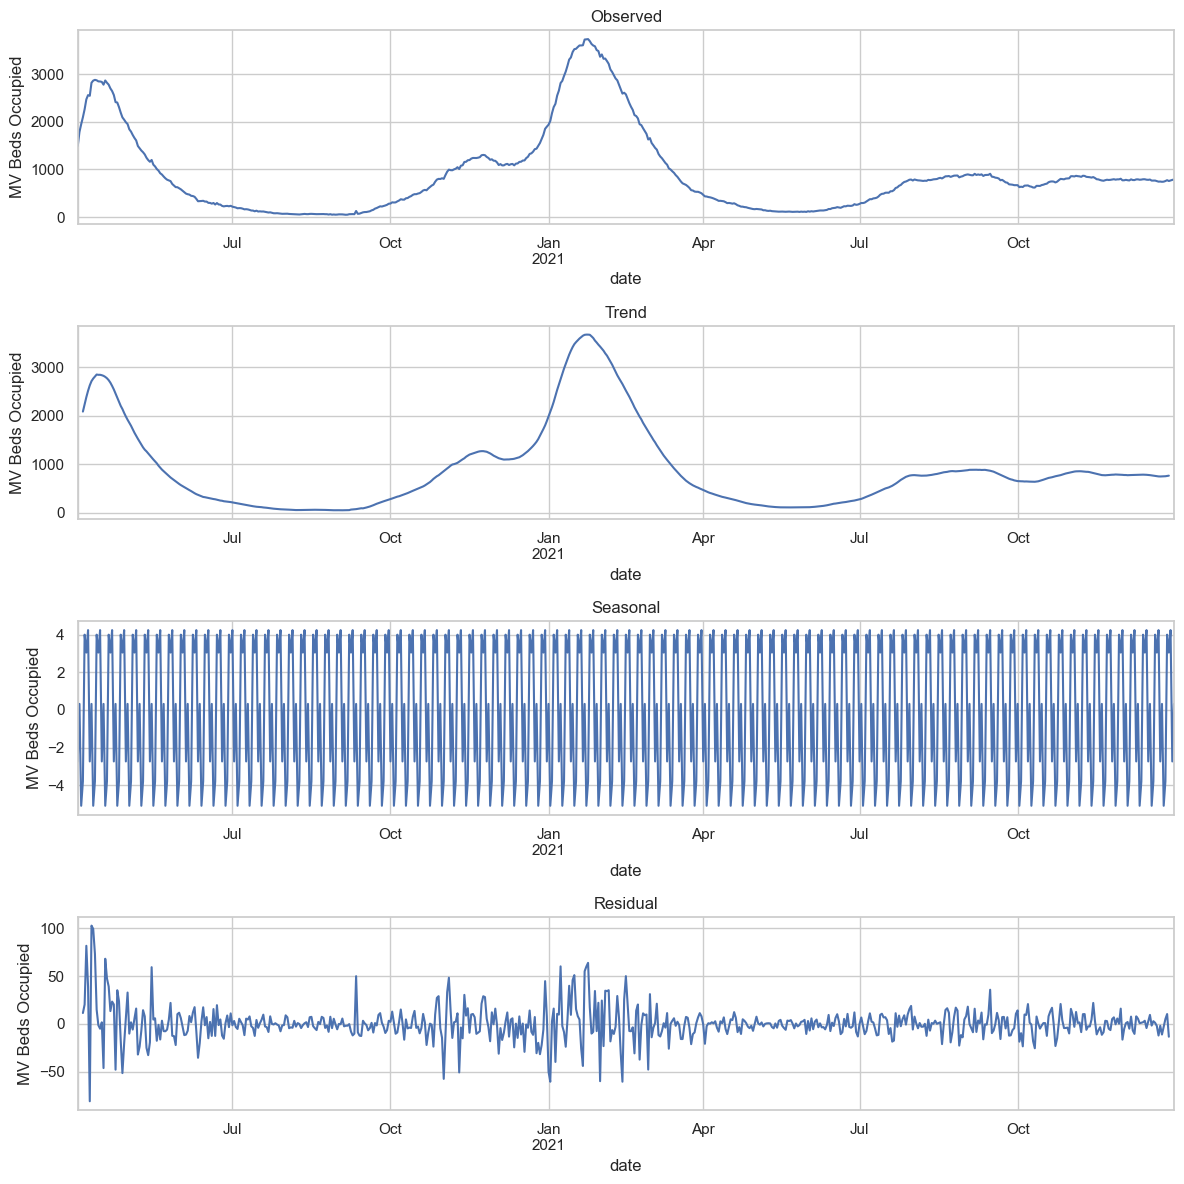

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposing the time series of mechanical ventilator demand
# Setting the model as 'additive' assuming linear relationship and constant seasonality over time
ts_data = enriched_data[["date", "MV Beds Occupied"]].set_index("date")
ts_data.dropna(inplace=True)  # Removing any NaN values for decomposition

# Assuming a weekly seasonality (7 days) for initial analysis
decomposition = seasonal_decompose(ts_data, model="additive", period=7)

# Plotting the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title("Observed")
ax1.set_ylabel("MV Beds Occupied")
decomposition.trend.plot(ax=ax2)
ax2.set_title("Trend")
ax2.set_ylabel("MV Beds Occupied")
decomposition.seasonal.plot(ax=ax3)
ax3.set_title("Seasonal")
ax3.set_ylabel("MV Beds Occupied")
decomposition.resid.plot(ax=ax4)
ax4.set_title("Residual")
ax4.set_ylabel("MV Beds Occupied")

plt.tight_layout()
plt.show()

In [49]:
# Descriptive Statistics
descriptive_stats = enriched_data.describe()

# Missing Data Analysis
missing_data = enriched_data.isnull().sum()

# Displaying Descriptive Statistics and Missing Data
descriptive_stats, missing_data

(                      date  MV Beds Occupied  Hospital Cases  New Admissions  \
 count                  639        639.000000      639.000000      639.000000   
 mean   2021-02-15 00:00:00        894.436620     7556.519562      815.549296   
 min    2020-04-02 00:00:00         50.000000      451.000000       25.000000   
 25%    2020-09-08 12:00:00        239.000000     1822.500000      188.500000   
 50%    2021-02-15 00:00:00        749.000000     5575.000000      651.000000   
 75%    2021-07-24 12:00:00       1094.000000    10212.500000     1049.500000   
 max    2021-12-31 00:00:00       3736.000000    34336.000000     4134.000000   
 std                    NaN        863.145027     7537.646283      812.021677   
 
        New COVID-19 Cases   Vax_index  stringency_index  \
 count          639.000000  639.000000        639.000000   
 mean         18390.993740    0.262554         57.734272   
 min            351.000000    0.094958         23.150000   
 25%           2319.500000   

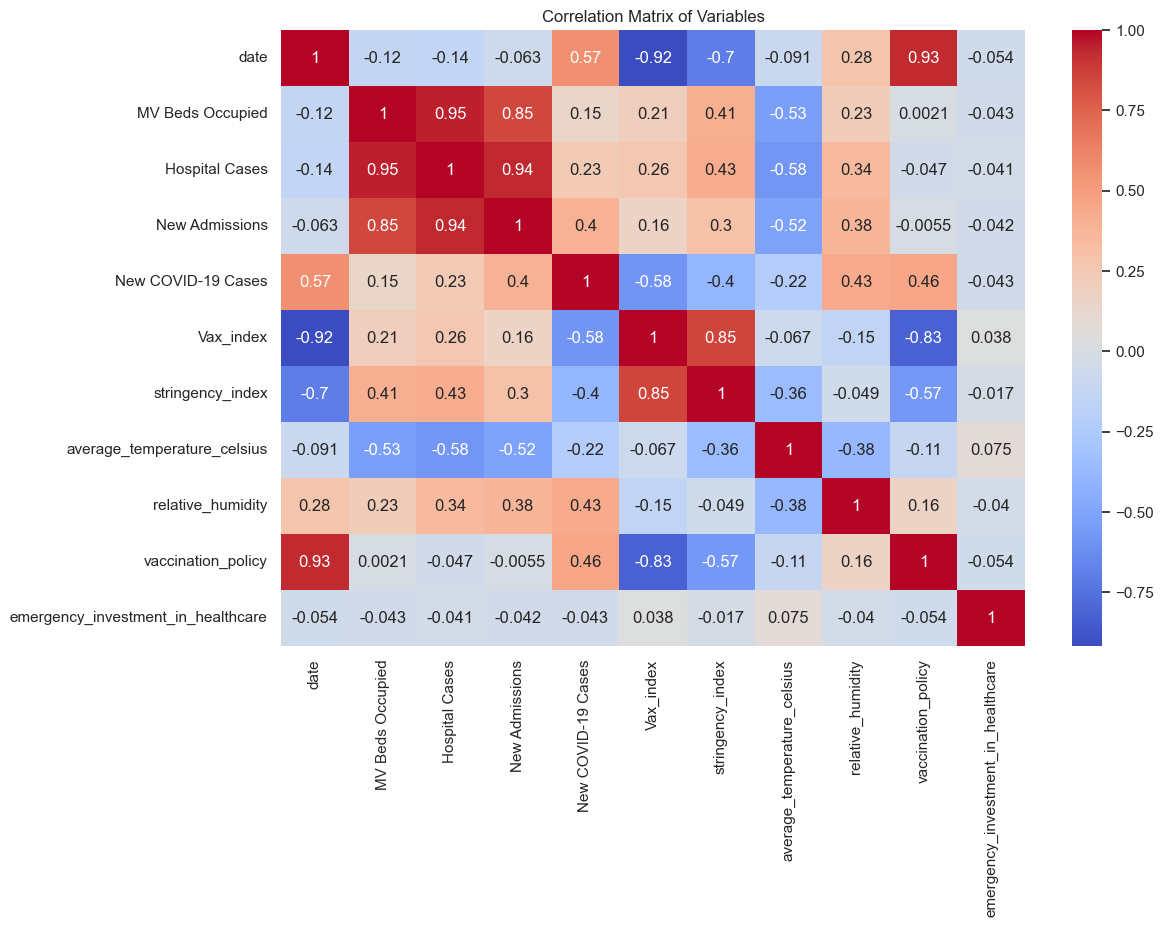

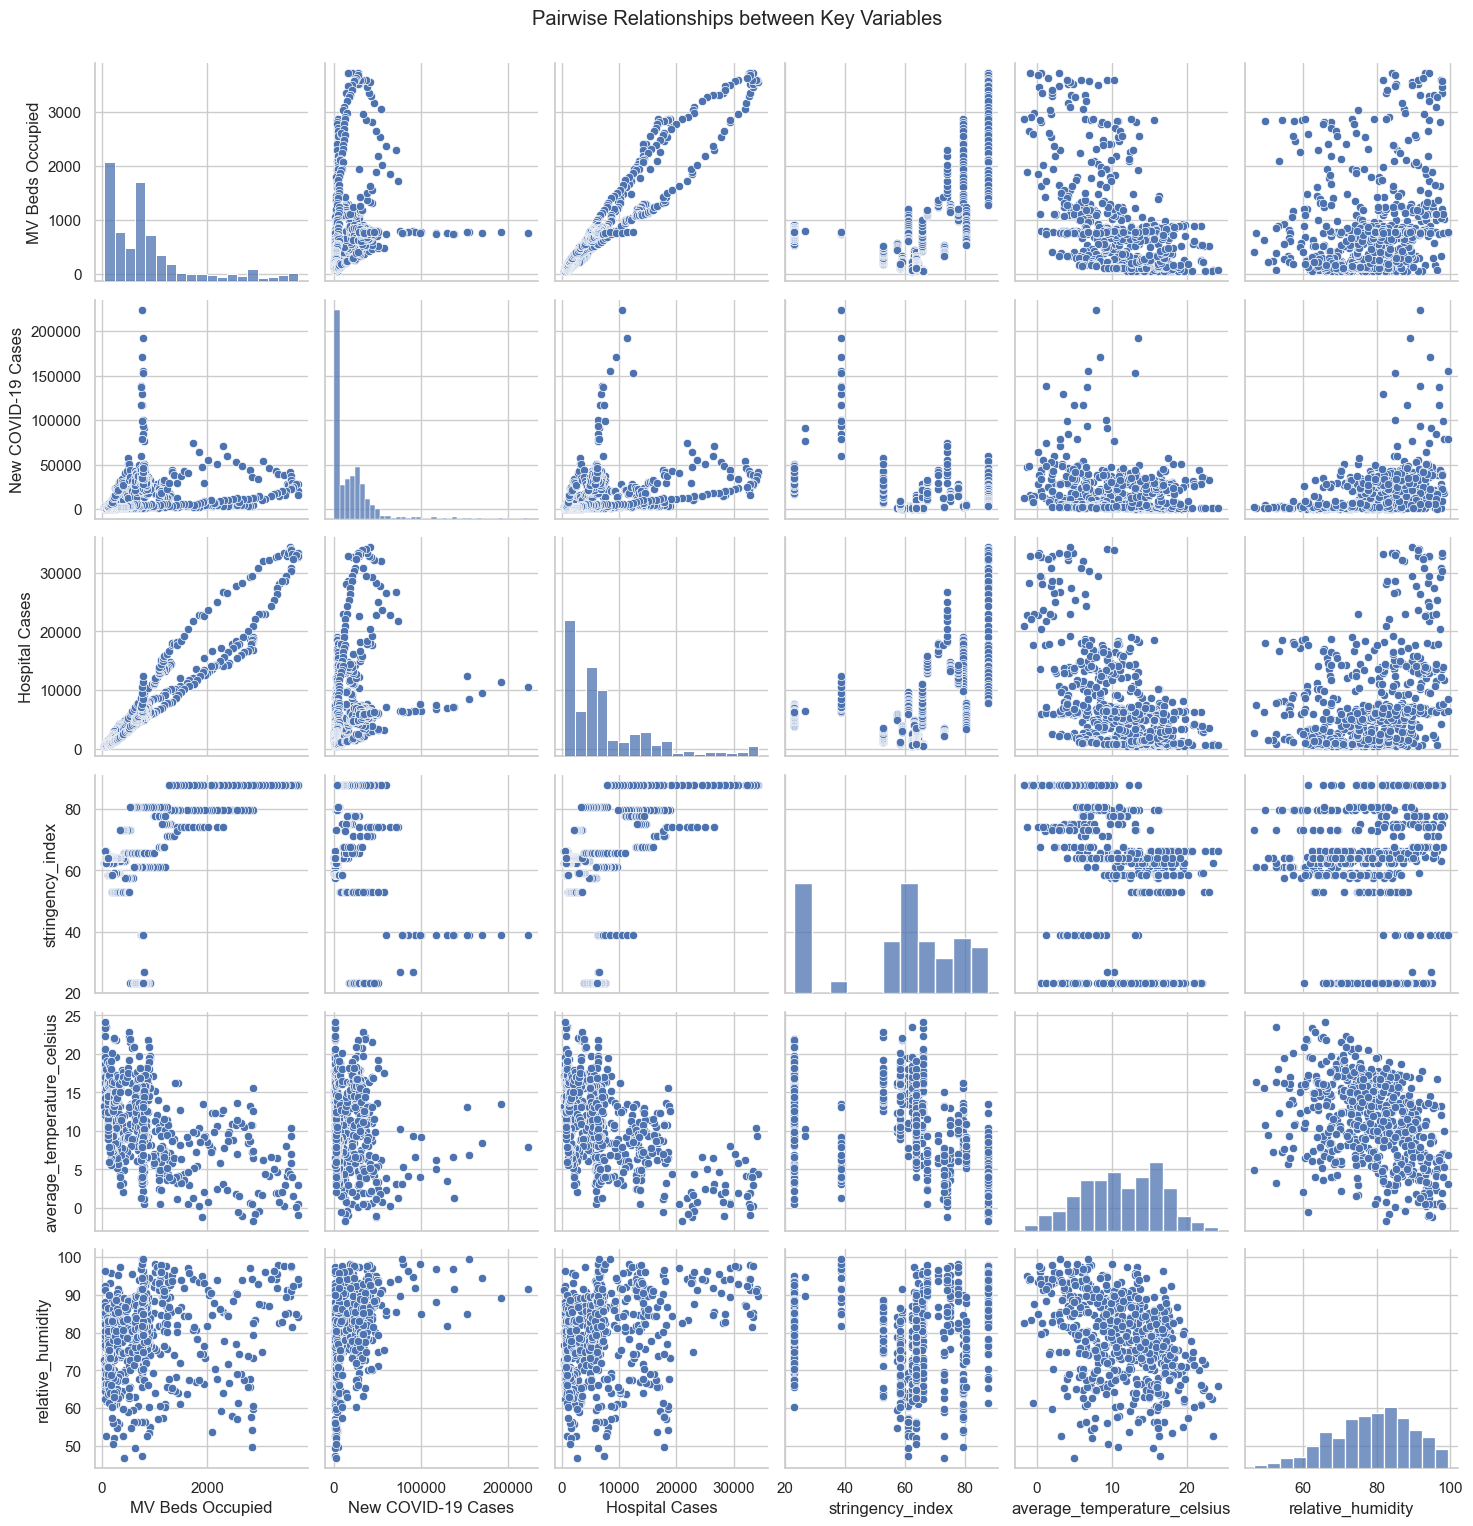

In [50]:
# Correlation Analysis
correlation_matrix = enriched_data.corr()

# Visualizing Correlation Matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Variables")
plt.show()

# Pairwise Relationships
# Selecting key variables for pairwise relationship analysis
pairwise_columns = [
    "MV Beds Occupied",
    "New COVID-19 Cases",
    "Hospital Cases",
    "stringency_index",
    "average_temperature_celsius",
    "relative_humidity",
]

# Plotting pairwise relationships
sns.pairplot(enriched_data[pairwise_columns])
plt.suptitle("Pairwise Relationships between Key Variables", y=1.02)
plt.show()

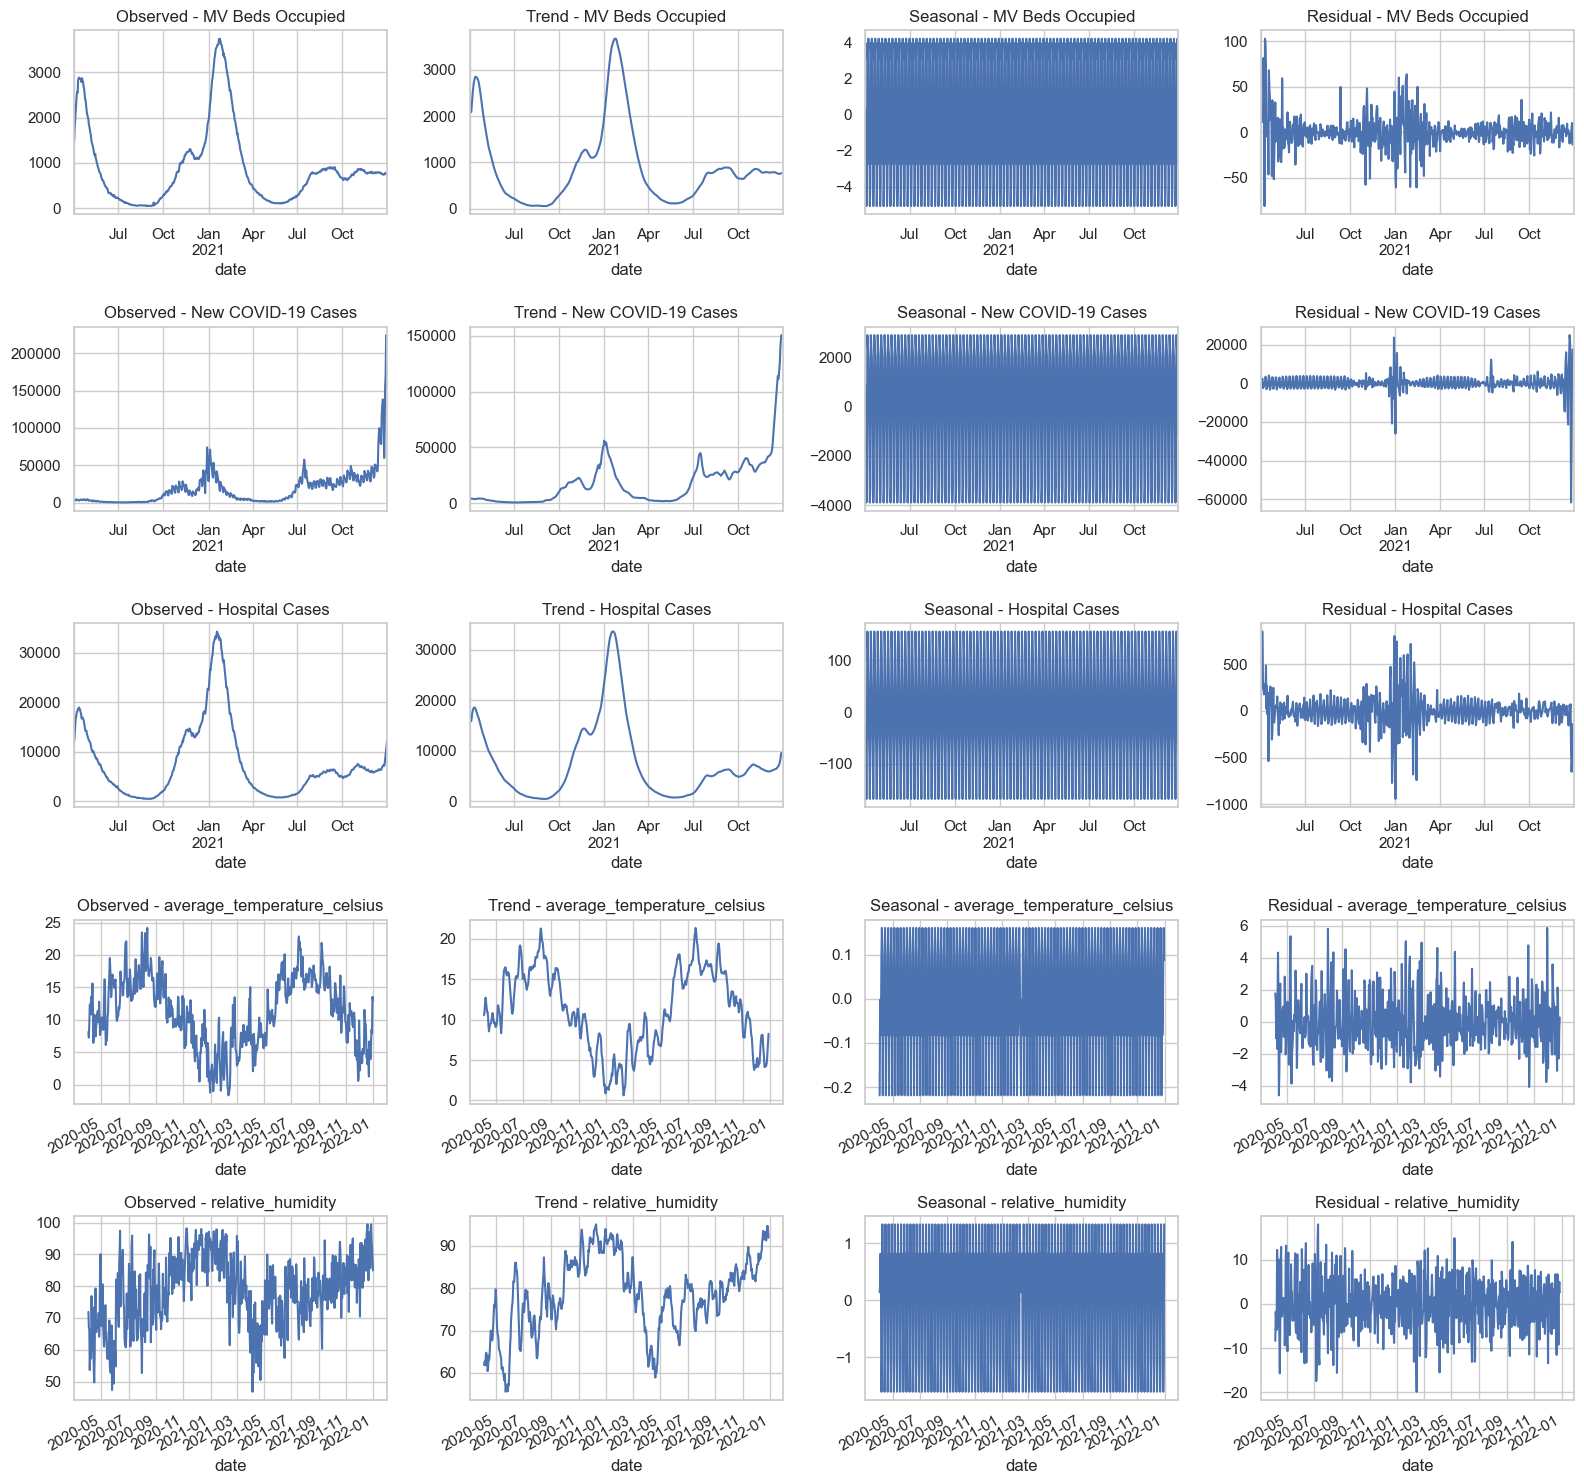

In [51]:
# Decomposing time series for each key variable
# Assuming a weekly seasonality (7 days) for initial analysis
decomposition_results = {}

for column in pairwise_columns:
    # Check if the column is a time series data (exclude stringency_index and vaccination_policy)
    if column not in ["stringency_index", "vaccination_policy"]:
        ts_data_column = enriched_data[["date", column]].set_index("date")
        ts_data_column.dropna(inplace=True)  # Removing NaN values for decomposition
        decomposition = seasonal_decompose(ts_data_column, model="additive", period=7)
        decomposition_results[column] = decomposition

# Plotting the decomposed components for each variable
fig, axes = plt.subplots(
    len(decomposition_results), 4, figsize=(16, 3 * len(decomposition_results))
)

for i, (column, decomposition) in enumerate(decomposition_results.items()):
    decomposition.observed.plot(ax=axes[i, 0], title=f"Observed - {column}")
    decomposition.trend.plot(ax=axes[i, 1], title=f"Trend - {column}")
    decomposition.seasonal.plot(ax=axes[i, 2], title=f"Seasonal - {column}")
    decomposition.resid.plot(ax=axes[i, 3], title=f"Residual - {column}")

plt.tight_layout()
plt.show()

In [52]:
# Feature Engineering: Creating lagged variables, rolling averages, and other features

# Selecting key variables for feature engineering
selected_columns = [
    "MV Beds Occupied",
    "New COVID-19 Cases",
    "Hospital Cases",
    "stringency_index",
    "average_temperature_celsius",
    "relative_humidity",
]

# Creating lagged variables (e.g., lag of 7 days)
for column in selected_columns:
    enriched_data[f"{column}_lag7"] = enriched_data[column].shift(7)

# Creating rolling averages (e.g., 7-day rolling window)
for column in selected_columns:
    enriched_data[f"{column}_rolling7"] = enriched_data[column].rolling(window=7).mean()

# Additional feature: Day of the Week as a categorical variable
enriched_data["day_of_week"] = enriched_data["date"].dt.dayofweek

# Displaying the first few rows of the dataset with new features
enriched_data.head()

,date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,Vax_index,stringency_index,average_temperature_celsius,relative_humidity,vaccination_policy,...,stringency_index_lag7,average_temperature_celsius_lag7,relative_humidity_lag7,MV Beds Occupied_rolling7,New COVID-19 Cases_rolling7,Hospital Cases_rolling7,stringency_index_rolling7,average_temperature_celsius_rolling7,relative_humidity_rolling7,day_of_week
0,2020-04-02,1494.0,12135.0,2932.0,4097,0.33,79.63,8.131944,71.895232,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
1,2020-04-03,1788.0,13635.0,2564.0,4102,0.33,79.63,7.250000,66.980840,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,2020-04-04,1950.0,15469.0,2593.0,3405,0.33,79.63,9.319444,66.459780,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,2020-04-05,2097.0,16657.0,2592.0,3094,0.33,79.63,12.291667,53.621480,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,2020-04-06,2264.0,17154.0,2679.0,4407,0.33,79.63,12.395833,59.204766,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [53]:
# Function to add traces. This improves readability and makes the code easier to modify.
def add_trace(fig, x_data, y_data, color, title, row):
    fig.add_trace(
        go.Scatter(
            x=x_data,
            y=y_data,
            mode="lines",
            line=dict(color=color, width=2),
            name=title,
            showlegend=True,  # Set to True to show legends
        ),
        row=row,
        col=1,
    )


# Create a subplot with 4 rows
fig_trend = make_subplots(
    rows=5,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,  # Adjust spacing between plots
    subplot_titles=(
        "Mechanical Ventilators Usage Over Time",
        "Daily Hospital Cases Over Time",
        "Daily New Admissions Over Time" "Daily COVID-19 Cases Over Time",
        "Vax_index",
    ),
)

# Data for plotting
data = [
    (
        enriched_data["date"],
        enriched_data["MV Beds Occupied"],
        "blue",
        "Mechanical Ventilators",
        1,
    ),
    (
        enriched_data["date"],
        enriched_data["Hospital Cases"],
        "brown",
        "Hospital Cases",
        2,
    ),
    (enriched_data["date"], model_data["New Admissions"], "green", "New Admissions", 3),
    (
        enriched_data["date"],
        enriched_data["New COVID-19 Cases"],
        "orange",
        "New COVID-19 Cases",
        4,
    ),

    (
        enriched_data["date"],
        enriched_data["Vax_index"],
        "purple",
        "Vax_index",
        5,
    ),
]

# Add data to the subplot
for item in data:
    add_trace(fig_trend, *item)

# Update the layout for better appearance
fig_trend.update_layout(
    height=1200,
    width=1000,  # Increased width for a better view
    template="plotly_white",
    title_text="Trend Analysis for Various COVID-19 Metrics",
    legend_title_text="Metrics",  # Add legend title
    hovermode="x unified",  # Unified hovermode for better tooltip display
)

# Update xaxis properties
fig_trend.update_xaxes(title_text="date", row=4, col=1)

# Update yaxis properties
fig_trend.update_yaxes(title_text="Count", row=1, col=1)
fig_trend.update_yaxes(title_text="Count", row=2, col=1)
fig_trend.update_yaxes(title_text="Count", row=3, col=1)
fig_trend.update_yaxes(title_text="Count", row=4, col=1)
fig_trend.update_yaxes(title_text="Count", row=5, col=1)
fig_trend.show()

In [54]:
fig_trend.write_image("../images/trend.pdf", format="pdf")

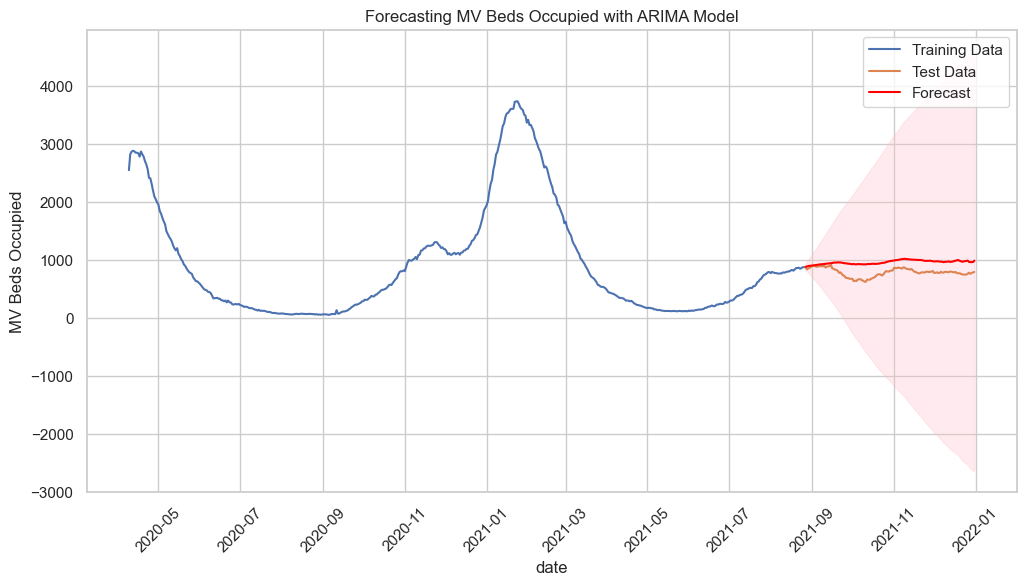

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import warnings

# Ignoring convergence warnings for demonstration purposes
warnings.filterwarnings("ignore")

# Preparing the dataset for ARIMA model
# Using 'MV Beds Occupied' as the target variable and a few selected features as exogenous variables
target = "MV Beds Occupied"
exogenous_variables = [
    "New COVID-19 Cases_lag7",
    "Hospital Cases_lag7",
    "stringency_index_rolling7",
]

# Dropping rows with NaN values that were introduced due to lag/rolling features
arima_data = enriched_data.dropna(subset=[target] + exogenous_variables)

# Splitting the data into training and testing sets
train_data, test_data = train_test_split(arima_data, test_size=0.2, shuffle=False)

# Defining the ARIMA model
# For simplicity, using basic parameters and not performing extensive hyperparameter tuning
model = SARIMAX(
    train_data[target], exog=train_data[exogenous_variables], order=(1, 1, 1)
)

# Fitting the model
fitted_model = model.fit(disp=False)

# Forecasting
forecast = fitted_model.get_forecast(
    steps=len(test_data), exog=test_data[exogenous_variables]
)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data["date"], train_data[target], label="Training Data")
plt.plot(test_data["date"], test_data[target], label="Test Data")
plt.plot(test_data["date"], forecast_values, label="Forecast", color="red")
plt.fill_between(
    test_data["date"],
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="pink",
    alpha=0.3,
)
plt.title("Forecasting MV Beds Occupied with ARIMA Model")
plt.xlabel("date")
plt.ylabel("MV Beds Occupied")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Hyperparameter tuning: Adjusting the order of the ARIMA model
# Trying a few different parameter combinations for demonstration
parameter_combinations = [
    (1, 1, 1),
    (1, 1, 2),
    (2, 1, 1),
    (2, 1, 2),
    (3, 1, 1),
    (3, 1, 2),
    (4, 1, 1),
    (4, 1, 2),
    (5, 1, 1),
    (5, 1, 2),
]
best_mae = np.inf
best_rmse = np.inf
best_order = None
best_model = None

for params in parameter_combinations:
    try:
        model = SARIMAX(
            train_data[target], exog=train_data[exogenous_variables], order=params
        )
        model_fit = model.fit(disp=False)

        # Forecasting
        forecast = model_fit.get_forecast(
            steps=len(test_data), exog=test_data[exogenous_variables]
        )
        forecast_values = forecast.predicted_mean

        # Calculating metrics
        mae = mean_absolute_error(test_data[target], forecast_values)
        rmse = np.sqrt(mean_squared_error(test_data[target], forecast_values))

        if mae < best_mae and rmse < best_rmse:
            best_mae = mae
            best_rmse = rmse
            best_order = params
            best_model = model_fit
    except:
        continue

# Best model's parameters and metrics
best_order, best_mae, best_rmse

((5, 1, 1), 125.5109289172018, 140.7834112072207)

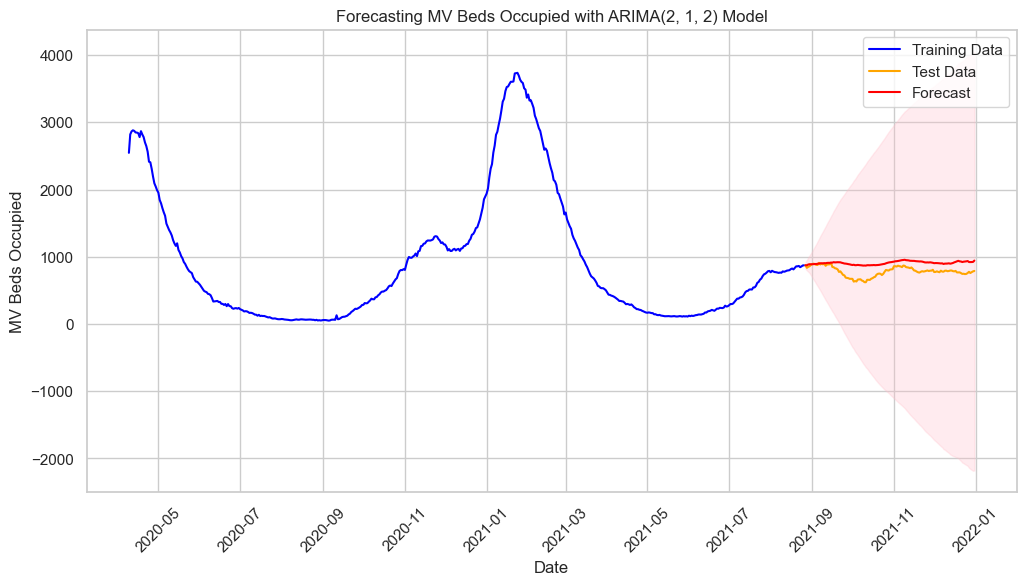

In [ ]:
# Using the best model (ARIMA(2, 1, 2)) for forecasting and visualization
forecast = best_model.get_forecast(
    steps=len(test_data), exog=test_data[exogenous_variables]
)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data["date"], train_data[target], label="Training Data", color="blue")
plt.plot(test_data["date"], test_data[target], label="Test Data", color="orange")
plt.plot(test_data["date"], forecast_values, label="Forecast", color="red")
plt.fill_between(
    test_data["date"],
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="pink",
    alpha=0.3,
)
plt.title("Forecasting MV Beds Occupied with ARIMA(2, 1, 2) Model")
plt.xlabel("Date")
plt.ylabel("MV Beds Occupied")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Preparing the dataset for Gradient Boosting model
# Using lagged and rolling features as predictors
predictors = [
    col for col in enriched_data.columns if "lag7" in col or "rolling7" in col
]
predictors += ["day_of_week"]

# Ensuring no NaN values in the dataset
ml_data = enriched_data.dropna(subset=[target] + predictors)

# Splitting the data into training and testing sets
train_ml_data, test_ml_data = train_test_split(ml_data, test_size=0.2, shuffle=False)

# Model Training
gb_model = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0
)
gb_model.fit(train_ml_data[predictors], train_ml_data[target])

# Model Evaluation
train_predictions = gb_model.predict(train_ml_data[predictors])
test_predictions = gb_model.predict(test_ml_data[predictors])

# Calculating metrics
train_mae = mean_absolute_error(train_ml_data[target], train_predictions)
test_mae = mean_absolute_error(test_ml_data[target], test_predictions)
train_rmse = np.sqrt(mean_squared_error(train_ml_data[target], train_predictions))
test_rmse = np.sqrt(mean_squared_error(test_ml_data[target], test_predictions))

# Metrics
train_mae, test_mae, train_rmse, test_rmse

(9.659513210782459, 31.095923787519357, 12.811805921857122, 37.70152602507616)

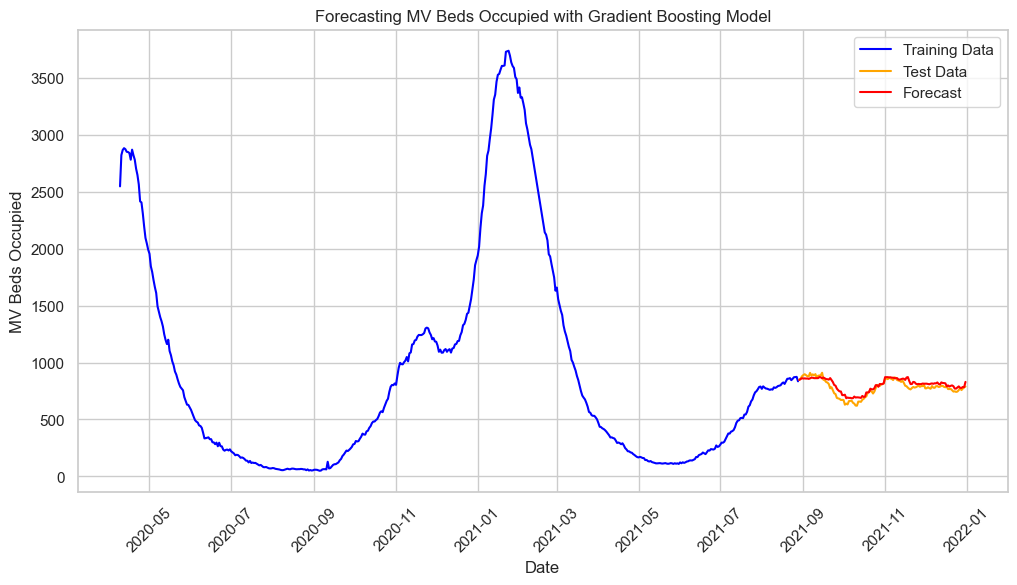

In [ ]:
# Plotting the results of the Gradient Boosting model
plt.figure(figsize=(12, 6))
plt.plot(
    train_ml_data["date"], train_ml_data[target], label="Training Data", color="blue"
)
plt.plot(test_ml_data["date"], test_ml_data[target], label="Test Data", color="orange")
plt.plot(test_ml_data["date"], test_predictions, label="Forecast", color="red")
plt.title("Forecasting MV Beds Occupied with Gradient Boosting Model")
plt.xlabel("Date")
plt.ylabel("MV Beds Occupied")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(train_ml_data[predictors], train_ml_data[target])
lr_train_predictions = lr_model.predict(train_ml_data[predictors])
lr_test_predictions = lr_model.predict(test_ml_data[predictors])

# Support Vector Regression Model
svr_model = SVR(kernel="rbf")
svr_model.fit(train_ml_data[predictors], train_ml_data[target])
svr_train_predictions = svr_model.predict(train_ml_data[predictors])
svr_test_predictions = svr_model.predict(test_ml_data[predictors])

# Metrics for Linear Regression
lr_train_mae = mean_absolute_error(train_ml_data[target], lr_train_predictions)
lr_test_mae = mean_absolute_error(test_ml_data[target], lr_test_predictions)
lr_train_rmse = np.sqrt(mean_squared_error(train_ml_data[target], lr_train_predictions))
lr_test_rmse = np.sqrt(mean_squared_error(test_ml_data[target], lr_test_predictions))

# Metrics for Support Vector Regression
svr_train_mae = mean_absolute_error(train_ml_data[target], svr_train_predictions)
svr_test_mae = mean_absolute_error(test_ml_data[target], svr_test_predictions)
svr_train_rmse = np.sqrt(
    mean_squared_error(train_ml_data[target], svr_train_predictions)
)
svr_test_rmse = np.sqrt(mean_squared_error(test_ml_data[target], svr_test_predictions))

# Compiling all metrics
metrics = {
    "Model": ["Gradient Boosting", "Linear Regression", "Support Vector Regression"],
    "Train MAE": [train_mae, lr_train_mae, svr_train_mae],
    "Test MAE": [test_mae, lr_test_mae, svr_test_mae],
    "Train RMSE": [train_rmse, lr_train_rmse, svr_train_rmse],
    "Test RMSE": [test_rmse, lr_test_rmse, svr_test_rmse],
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE
0,Gradient Boosting,9.659513,31.095924,12.811806,37.701526
1,Linear Regression,16.841358,29.600804,26.190555,48.780366
2,Support Vector Regression,607.866311,177.044536,956.387906,191.105734


## Scenario Analysis in Forecasting Demand for Mechanical Ventilators

- **Scenerio A (high infection rate)**
- **Scenerio B (Increased Hospitalisation rate)**
- **Scenerio C (Efectiuve Vaccination Campaign)**
- **Scenerio D (Resource Strain)**
